Васильев Семён, 620, №02210056 (16), Вариант 6

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.decomposition import NMF
from sklearn.covariance import GraphicalLasso
from scipy.sparse.csgraph import connected_components
import torch
import torch.nn as nn

In [2]:
#1
data = pd.read_csv('data.csv')
data

,CUSTOMER,TIME,PRODUCT
0,0,0,hering
1,0,1,corned_b
2,0,2,olives
3,0,3,ham
4,0,4,turkey
...,...,...,...
7002,1000,2,apples
7003,1000,3,olives
7004,1000,4,steak
7005,1000,5,bourbon


In [3]:
#1 Сколько различных значений принимают переменные Product и Customer.
print(f'Число уникальных значений переменной CUSTOMER: {len(np.unique(data["CUSTOMER"]))}')
print(f'Число уникальных значений переменной PRODUCT: {len(np.unique(data["PRODUCT"]))}')

Число уникальных значений переменной CUSTOMER: 1001
Число уникальных значений переменной PRODUCT: 20


In [4]:
trans_encoder = TransactionEncoder()
trans = trans_encoder \
    .fit_transform(data.groupby('CUSTOMER').aggregate({"PRODUCT": list}).values[:,0])
trans = pd.DataFrame(trans, columns=trans_encoder.columns_)
trans

,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
0,False,False,False,False,False,True,False,False,True,False,True,False,True,True,True,False,False,False,False,True
1,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,False,True,False,False
2,False,True,True,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,True
3,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,True,False,False,False,True
4,True,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,False,True,True,False,False,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False
997,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,False,False,False,True
998,False,False,False,True,False,False,False,False,False,True,False,True,True,False,False,False,True,True,False,False
999,False,False,False,False,False,False,True,True,True,False,False,True,False,True,False,True,True,False,False,False


In [5]:
#2
freq_itemsets = fpgrowth(trans, min_support=0.04, use_colnames=True)

In [6]:
#2 Частые эпизоды с ограничением на размер правила равным 4.
freq_itemsets[list(map(lambda x: len (x) >= 4, freq_itemsets['itemsets']))]

,support,itemsets
29,0.044955,"(hering, olives, heineken, cracker)"
39,0.108891,"(bourbon, heineken, olives, cracker)"
94,0.117882,"(ham, olives, corned_b, hering)"
102,0.100899,"(ham, heineken, avocado, cracker)"
125,0.102897,"(ham, turkey, olives, hering)"
...,...,...
421,0.096903,"(corned_b, olives, apples, steak)"
422,0.096903,"(hering, olives, apples, steak)"
423,0.096903,"(corned_b, hering, apples, steak)"
424,0.096903,"(corned_b, steak, hering, olives, apples)"


In [7]:
#3 Найдите самый большой (где больше всего элементов) частый эпизод, содержащий продукт
#  согласно вашему варианту. Какая у него поддержка?
t = freq_itemsets[list(map(lambda x: 'heineken' in x, freq_itemsets['itemsets']))]
t[list(map(
    lambda x: len(x) == max(list(map(lambda x: len(x), t['itemsets']))), t['itemsets'])
)]

,support,itemsets
186,0.114885,"(baguette, hering, soda, heineken, cracker)"
197,0.105894,"(soda, heineken, cracker, olives, bourbon)"
245,0.098901,"(ham, heineken, avocado, cracker, artichok)"
255,0.098901,"(baguette, hering, heineken, avocado, artichok)"
296,0.115884,"(chicken, heineken, coke, sardines, ice_crea)"


In [8]:
#4 На основе найденных частых эпизодов постройте ассоциативные правила с порогом на
#  достоверность согласно вашему варианту
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(hering),(heineken),0.485514,0.599401,0.287712,0.592593,0.988642,-0.003305,0.983289
1,"(heineken, hering)",(cracker),0.287712,0.487512,0.162837,0.565972,1.160939,0.022574,1.180771
2,"(cracker, hering)",(heineken),0.200799,0.599401,0.162837,0.810945,1.352927,0.042478,2.118960
3,(olives),(hering),0.472527,0.485514,0.255744,0.541226,1.114748,0.026325,1.121436
4,(hering),(olives),0.485514,0.472527,0.255744,0.526749,1.114748,0.026325,1.114572
...,...,...,...,...,...,...,...,...,...
998,"(chicken, hering)",(heineken),0.092907,0.599401,0.052947,0.569892,0.950771,-0.002742,0.931394
999,"(chicken, avocado)",(heineken),0.055944,0.599401,0.043956,0.785714,1.310833,0.010423,1.869464
1000,"(soda, chicken)",(cracker),0.065934,0.487512,0.052947,0.803030,1.647199,0.020803,2.601860
1001,"(soda, chicken)",(heineken),0.065934,0.599401,0.048951,0.742424,1.238611,0.009430,1.555268


In [9]:
#4 Найдите правило с максимальным лифтом, 
#  содержащем продукт из вашего варианта в левой части правила.
t = rules[list(map(lambda x: 'heineken' in x, rules['antecedents']))]#.reset_index(drop=True)
t[t['lift'] == t['lift'].max()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
640,"(coke, heineken, sardines)","(ice_crea, chicken)",0.11988,0.13986,0.115884,0.966667,6.911667,0.099118,25.804196


Support = 0.1158 - доля транзакций, содержащих объединение товаров из левой и правой частей правила.

Confidence = 0.9667 - вероятность наличия в чеке товаров из правой части при условии наличия в чеке товаров из левой части.

Lift = 6.9117 - вероятность наличия в чеке товаров из правой части при условии наличия в чеке товаров из левой в 6.9117 раз больше, чем безусловная вероятность наличия в чеке товаров из правой части.

In [10]:
#5 Используя только двухместные правила постройте ориентированный граф, где вершины
#  элементы правила, их цвет (или размер) – поддержка элемента (item support), дуги –
#  импликации (ориентированы в направлении от условия к следствию), веса дугu –
#  достоверности.
G = nx.Graph()
node_supp = {}
for i in range(rules.shape[0]):
    row = rules.iloc[i]
    if len(row['antecedents']) == 1 and len(row['consequents']) == 1:
        from_node = list(row['antecedents'])[0]
        to_node = list(row['consequents'])[0]
        node_supp[from_node] = row['antecedent support']
        node_supp[to_node] = row['consequent support']
        G.add_edge(
            from_node, 
            to_node,
            weight=round(row['confidence'], 3)
        )
node_sizes = [1000 * node_supp[node.split('-')[0]] for node in G.nodes]

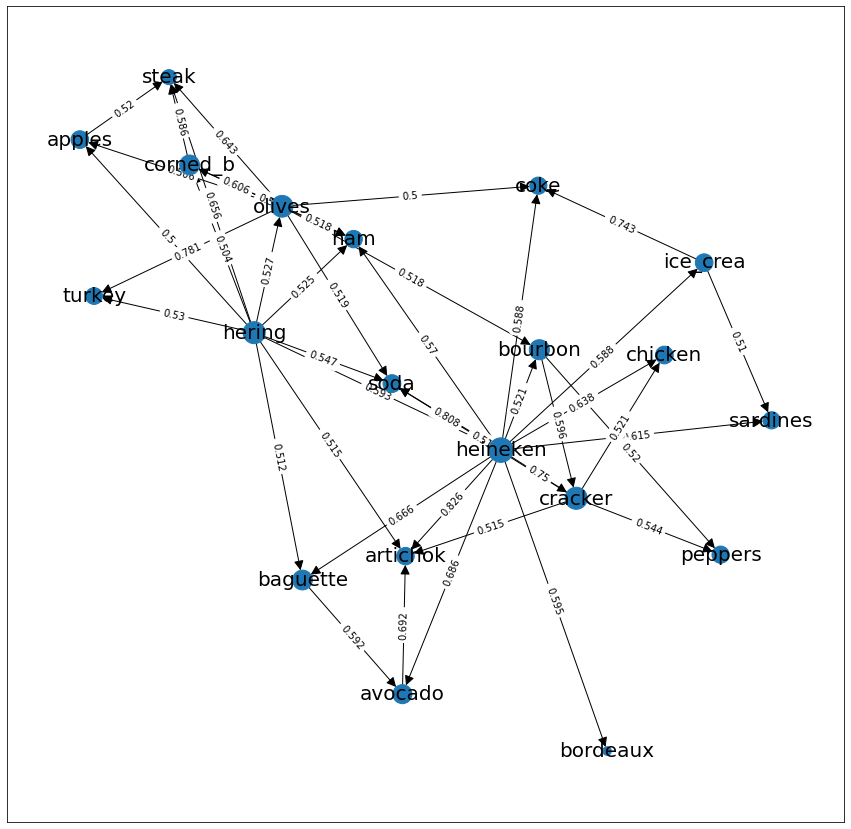

In [11]:
#5
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G)
nx.draw_networkx(
    G, pos, 
    arrows=True, arrowsize=20,
    node_size=node_sizes, with_labels=True, 
    font_size=20
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'));

In [12]:
#6 Для данного графа рассчитайте меры центральности согласно вашему варианту и найдите
#  элемент с самой высокой мерой, а также какую меру имеет продукт из вашего варианта.
betweenness = nx.betweenness_centrality(G)
print(f'Max betweenness: {max(betweenness.items(), key=lambda x: x[1])}')
print(f'Heineken betweenness: {betweenness["heineken"]}')

Max betweenness: ('heineken', 0.4722918407128934)
Heineken betweenness: 0.4722918407128934


In [13]:
#7 Постройте числовую матрицу со счетчиком числа покупок в ячейках, клиентами по строкам и
#  продуктами по столбцам.
customer2idx = {customer: i for i, customer in enumerate(np.unique(data['CUSTOMER']))}
product2idx = {product: i for i, product in enumerate(np.unique(data['PRODUCT']))}
values = data[['CUSTOMER', 'PRODUCT']].values
counter = np.zeros((len(customer2idx), len(product2idx)), dtype=int)
for i in range(len(values)):
    counter[customer2idx[values[i, 0]], product2idx[values[i, 1]]] += 1
counter

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]])

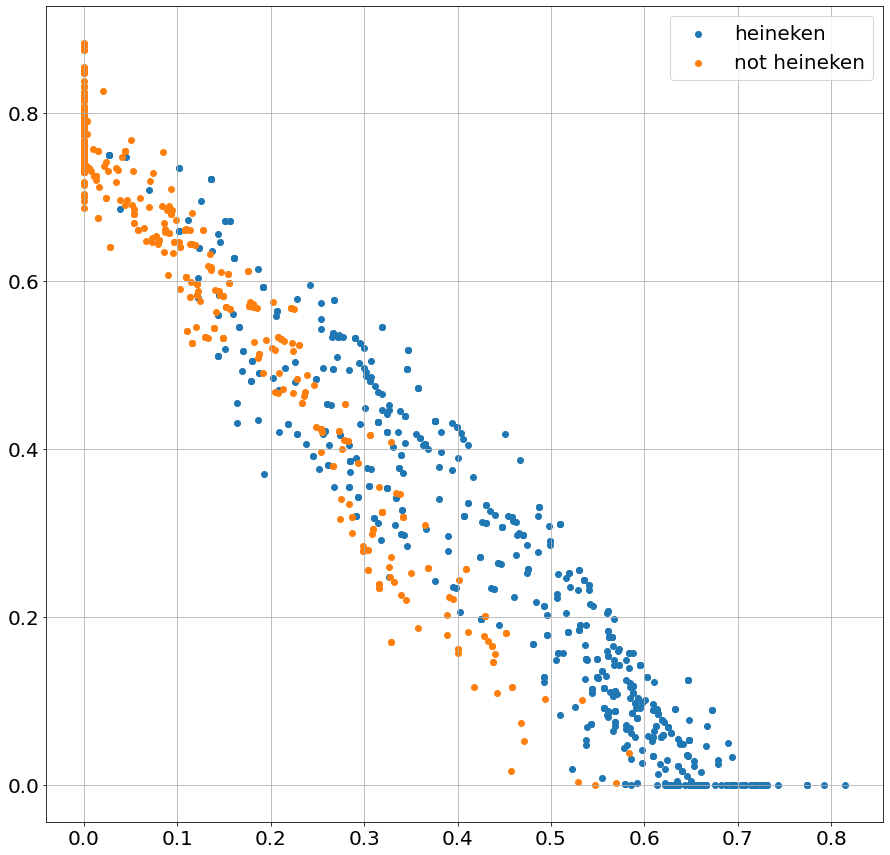

In [14]:
#8 С помощью метода из вашего варианта постройте линейную проекцию набора данных на
#  плоскость (2 компоненты) цветом укажите транзакции, содержащие продукт вашего варианта.
nmf = NMF(n_components=2, init='random')
nmf_counter = nmf.fit_transform(counter)
heineken_mask = (counter[:, product2idx['heineken']] > 0)

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(15, 15))
plt.grid()

plt.scatter(nmf_counter[heineken_mask, 0], nmf_counter[heineken_mask, 1], label='heineken')
plt.scatter(nmf_counter[~heineken_mask, 0], nmf_counter[~heineken_mask, 1], label='not heineken')
plt.legend();

In [15]:
counter.shape

(1001, 20)

In [16]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(counter.shape[1], 100),
            nn.ReLU(),
#             nn.Linear(400, 100),
#             nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
#             nn.Linear(100, 400),
#             nn.ReLU(),
            nn.Linear(100, counter.shape[1]),
        )
    
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [17]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

100%|███████████████████████████████████████| 8000/8000 [01:59<00:00, 66.98it/s]


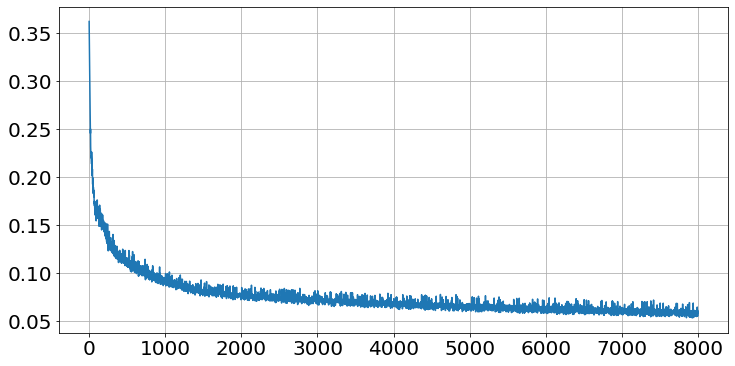

In [18]:
torch.manual_seed(1)

autoencoder = AE()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-4, weight_decay = 1e-8)

dataset = SimpleDataset(torch.FloatTensor(counter), torch.FloatTensor(counter))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

epoch_num = 8000
losses = []
for epoch in tqdm(range(epoch_num)):
    full_loss = 0
    c = 0
    for X, y in dataloader:
        optimizer.zero_grad()
        output = autoencoder(X)
        loss = loss_func(X, output)
        full_loss += loss.item()
        c += 1
        loss.backward()
        optimizer.step()
    full_loss /= c
    losses.append(full_loss)
    
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(list(range(epoch_num)), losses)

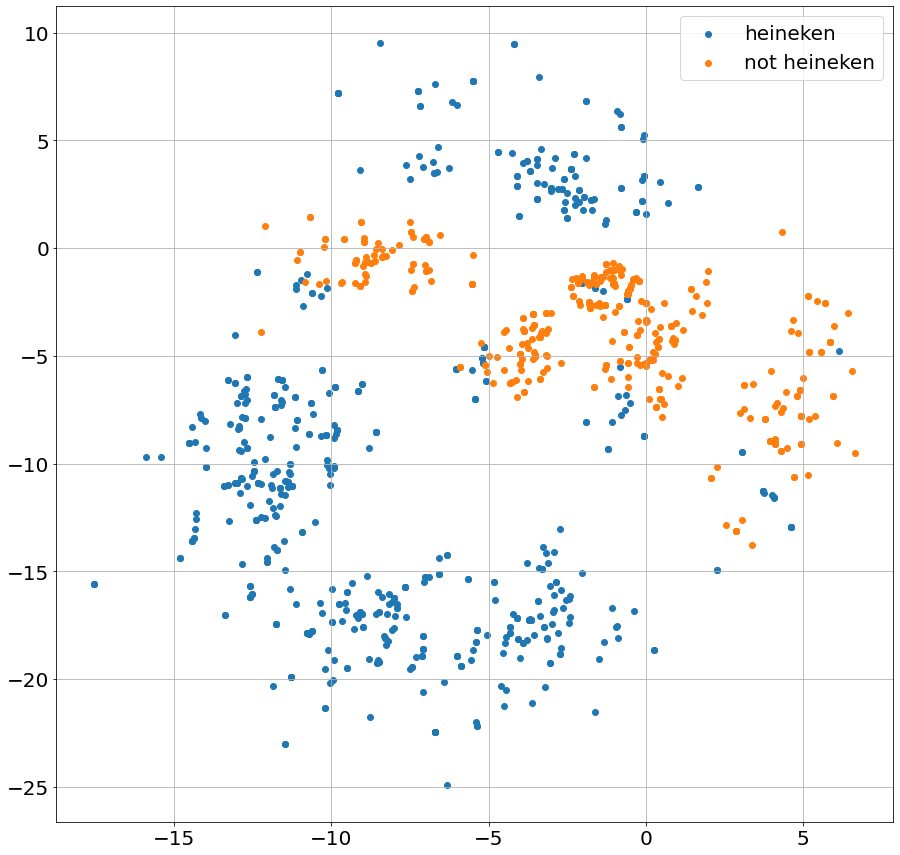

In [19]:
#9 С помощью метода из вашего варианта постройте нелинейную проекцию набора данных на
#  плоскость цветом укажите транзакции, содержащие продукт из вашего варианта. Не
#  указанные в задании параметры (например, размер решетки для SOM или число слоев в
#  автоэнкодере можно выбирать на свое усмотрение для получение наиболее удобной
#  визуализации). Дайте письменный комментарий, чем с вашей точки зрения для вашего
#  примера лучше или хуже нелинейная проекция).
counter_autoencoder = autoencoder.encoder(torch.FloatTensor(counter)).detach().numpy()

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(15, 15))
plt.grid()

plt.scatter(counter_autoencoder[heineken_mask, 0], 
            counter_autoencoder[heineken_mask, 1], 
            label='heineken')
plt.scatter(counter_autoencoder[~heineken_mask, 0], 
            counter_autoencoder[~heineken_mask, 1], 
            label='not heineken')
plt.legend();

Нелинейная проекция получилась более разделимой, но требует большего времени для обучения.

In [20]:
#10 Из исходной матрицы (из пункта 7) согласно вашему варианту отберите 
#   указанное число независимых переменных с использованием заданного метода.
columns = [None] * len(product2idx)
for p in product2idx:
    columns[product2idx[p]] = p
counter_01 = pd.DataFrame(counter, columns=columns)

hierarchy = []
step = []
cov = GraphicalLasso(alpha=0.07, max_iter=1000).fit(counter_01)
distance = np.abs(cov.covariance_) > 0
n, clusters = connected_components(distance, directed=False)
for j in range(clusters.max() + 1):
    cluster = frozenset(counter_01.columns[clusters==j])
    hierarchy.append(cluster)
    step.append(cluster)
step

[frozenset({'apples',
            'artichok',
            'avocado',
            'baguette',
            'bourbon',
            'coke',
            'corned_b',
            'cracker',
            'heineken',
            'hering',
            'ice_crea',
            'olives',
            'peppers',
            'sardines',
            'soda',
            'turkey'}),
 frozenset({'bordeaux'}),
 frozenset({'chicken'}),
 frozenset({'ham'}),
 frozenset({'steak'})]